In [1]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
import scipy.sparse as sparse

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1]]
                data.append(columns)

    return data

def import_csv2(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10] ]
                data.append(columns)

    return data

def import_csv3(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10], row[11] ]
                data.append(columns)

    return data

def import_csv4(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4]]
                data.append(columns)

    return data

In [3]:
tcp_cca = (['TcpCubic-0.000001', 'TcpBbr-0.000001', 
            'TcpQtColFair_1.2minRTT-0.000001', 'TcpQtColFair_1.5minRTT-0.000001',
            'TcpCubic-0.000010', 'TcpBbr-0.000010', 
            'TcpQtColFair_1.2minRTT-0.000010', 'TcpQtColFair_1.5minRTT-0.000010',
            'TcpCubic-0.000100', 'TcpBbr-0.000100', 
            'TcpQtColFair_1.2minRTT-0.000100', 'TcpQtColFair_1.5minRTT-0.000100',
            'TcpCubic-0.001000', 'TcpBbr-0.001000', 
            'TcpQtColFair_1.2minRTT-0.001000', 'TcpQtColFair_1.5minRTT-0.001000',
            'TcpCubic-0.010000', 'TcpBbr-0.010000', 
            'TcpQtColFair_1.2minRTT-0.010000', 'TcpQtColFair_1.5minRTT-0.010000'
           ])
BDP = 172
buffer_size = 1727 
print(buffer_size, tcp_cca)

1727 ['TcpCubic-0.000001', 'TcpBbr-0.000001', 'TcpQtColFair_1.2minRTT-0.000001', 'TcpQtColFair_1.5minRTT-0.000001', 'TcpCubic-0.000010', 'TcpBbr-0.000010', 'TcpQtColFair_1.2minRTT-0.000010', 'TcpQtColFair_1.5minRTT-0.000010', 'TcpCubic-0.000100', 'TcpBbr-0.000100', 'TcpQtColFair_1.2minRTT-0.000100', 'TcpQtColFair_1.5minRTT-0.000100', 'TcpCubic-0.001000', 'TcpBbr-0.001000', 'TcpQtColFair_1.2minRTT-0.001000', 'TcpQtColFair_1.5minRTT-0.001000', 'TcpCubic-0.010000', 'TcpBbr-0.010000', 'TcpQtColFair_1.2minRTT-0.010000', 'TcpQtColFair_1.5minRTT-0.010000']


In [4]:
num_flows = 5
cwnd = {}
agg_cwnd = {}
inflight = {}
rtt = {}

for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}


    agg_cwnd[algorithm] = {'time': list(), 'agg_cwnd': list(), 'agg_inflight': list(),
                'aveRtt': list(), 'agg_insThruput': list(), 'agg_aveThruput': list(), 
                'agg_insGoodput': list(), 'agg_aveGoodput': list(), 'agg_TxPkts': list(), 
                'agg_ReTxPkts': list(), 'fairness': list(), 'agg_cost': list()}
        
    for i in range(num_flows):
        cwnd[algorithm][i] = {'time': list(), 'cwnd': list(), 'inflight': list(),
                'rtt': list(), 'insThruput': list(), 'aveThruput': list(), 
                'insGoodput': list(), 'aveGoodput': list(), 'TxPkts': list(), 'ReTxPkts': list(), 
                'cost': list()}
                                       
        inflight[algorithm][i] = {'time': list(), 'inflight': list(), 'cwnd': list(), 
                                           'rtt': list(), 'cost': list()}
        rtt[algorithm][i] = {'time': list(), 'rtt': list()}

cwnd_files = []
agg_cwnd_files = []
inflight_files = []
rtt_files = []
                                               
for algorithm in tcp_cca:
    print(algorithm)
    
    agg_cwnd_files.append("../results/qt_lossy/" + str(algorithm) + "/" + 
                str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                "p-" + "Agg" + "-cwnd.data")
    cwnd_flows_files = []
    inflight_flows_files = []
    rtt_flows_files = []
    
    for i in range(num_flows):
        cwnd_flows_files.append("../results/qt_lossy/" + str(algorithm) + "/" + 
                    str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                    algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                    "p-flow" + str(i) + "-cwnd.data")
 #       inflight_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
 #                   str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
 #                   algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
 #                   "p-flow" + str(i) + "-inflight.data")
 #       rtt_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
 #                       str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
 #                       algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
 #                       "p-flow" + str(i) + "-rtt.data")
        
    cwnd_files.append(cwnd_flows_files)
    inflight_files.append(inflight_flows_files)
    rtt_files.append(rtt_flows_files)



TcpCubic-0.000001
TcpBbr-0.000001
TcpQtColFair_1.2minRTT-0.000001
TcpQtColFair_1.5minRTT-0.000001
TcpCubic-0.000010
TcpBbr-0.000010
TcpQtColFair_1.2minRTT-0.000010
TcpQtColFair_1.5minRTT-0.000010
TcpCubic-0.000100
TcpBbr-0.000100
TcpQtColFair_1.2minRTT-0.000100
TcpQtColFair_1.5minRTT-0.000100
TcpCubic-0.001000
TcpBbr-0.001000
TcpQtColFair_1.2minRTT-0.001000
TcpQtColFair_1.5minRTT-0.001000
TcpCubic-0.010000
TcpBbr-0.010000
TcpQtColFair_1.2minRTT-0.010000
TcpQtColFair_1.5minRTT-0.010000


In [5]:
print(agg_cwnd_files[0])
print(agg_cwnd_files[1])
print(agg_cwnd_files[2])

../results/qt_lossy/TcpCubic-0.000001/5-flows/100Mbps-20ms/1727p-btlqueue/TcpCubic-0.000001-5-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/qt_lossy/TcpBbr-0.000001/5-flows/100Mbps-20ms/1727p-btlqueue/TcpBbr-0.000001-5-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/qt_lossy/TcpQtColFair_1.2minRTT-0.000001/5-flows/100Mbps-20ms/1727p-btlqueue/TcpQtColFair_1.2minRTT-0.000001-5-flows-100Mbps-20ms-1727p-Agg-cwnd.data


In [6]:

for algorithm  in tcp_cca:
    index_alg = tcp_cca.index(algorithm)
    print(algorithm,index_alg)

    agg_cwnd_data_in = import_csv3(agg_cwnd_files[index_alg])
    for row in agg_cwnd_data_in: 
        agg_cwnd[algorithm]['time'].append(row[0])
        agg_cwnd[algorithm]['agg_cwnd'].append(row[1])
        agg_cwnd[algorithm]['agg_inflight'].append(row[2])
        agg_cwnd[algorithm]['aveRtt'].append(row[3])
        agg_cwnd[algorithm]['agg_insThruput'].append(row[4])
        agg_cwnd[algorithm]['agg_aveThruput'].append(row[5])
        agg_cwnd[algorithm]['agg_insGoodput'].append(row[6])
        agg_cwnd[algorithm]['agg_aveGoodput'].append(row[7])
        agg_cwnd[algorithm]['agg_TxPkts'].append(row[8])
        agg_cwnd[algorithm]['agg_ReTxPkts'].append(row[9])
        agg_cwnd[algorithm]['fairness'].append(row[10])
        agg_cwnd[algorithm]['agg_cost'].append(row[11])


TcpCubic-0.000001 0
TcpBbr-0.000001 1
TcpQtColFair_1.2minRTT-0.000001 2
TcpQtColFair_1.5minRTT-0.000001 3
TcpCubic-0.000010 4
TcpBbr-0.000010 5
TcpQtColFair_1.2minRTT-0.000010 6
TcpQtColFair_1.5minRTT-0.000010 7
TcpCubic-0.000100 8
TcpBbr-0.000100 9
TcpQtColFair_1.2minRTT-0.000100 10
TcpQtColFair_1.5minRTT-0.000100 11
TcpCubic-0.001000 12
TcpBbr-0.001000 13
TcpQtColFair_1.2minRTT-0.001000 14
TcpQtColFair_1.5minRTT-0.001000 15
TcpCubic-0.010000 16
TcpBbr-0.010000 17
TcpQtColFair_1.2minRTT-0.010000 18
TcpQtColFair_1.5minRTT-0.010000 19


In [8]:
cwnd_time = []
cwnd_value = []
inflight_value = []
rtt_value = []
insThruput_value = []
aveThruput_value = []
insGoodput_value = []
aveGoodput_value = []
cost_value = []

inflight2_time = []
inflight2_value = []
cwnd2_value = []
rtt2_value = []
cost2_value = []
rtt3_time = []
rtt3_value = []

agg_cwnd_time = []
agg_cwnd_value = []
agg_inflight_value = []
agg_rtt_value = []
agg_insThruput_value = []
agg_aveThruput_value = []
agg_insGoodput_value = []
agg_aveGoodput_value = []
fairness_value = []
agg_cost_value = []

for algorithm in tcp_cca:
    print(algorithm)

    agg_cwnd_time.append(pd.DataFrame(agg_cwnd[algorithm]['time']).to_numpy(dtype=float))
    agg_cwnd_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cwnd']).to_numpy(dtype=float))
    agg_inflight_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_inflight']).to_numpy(dtype=float))
    agg_rtt_value.append(pd.DataFrame(agg_cwnd[algorithm]['aveRtt']).to_numpy(dtype=float))
    agg_insThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insThruput']).to_numpy(dtype=float))  
    agg_aveThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveThruput']).to_numpy(dtype=float))  
    agg_insGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insGoodput']).to_numpy(dtype=float))  
    agg_aveGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveGoodput']).to_numpy(dtype=float)) 
    fairness_value.append(pd.DataFrame(agg_cwnd[algorithm]['fairness']).to_numpy(dtype=float)) 
    agg_cost_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cost']).to_numpy(dtype=float)) 


TcpCubic-0.000001
TcpBbr-0.000001
TcpQtColFair_1.2minRTT-0.000001
TcpQtColFair_1.5minRTT-0.000001
TcpCubic-0.000010
TcpBbr-0.000010
TcpQtColFair_1.2minRTT-0.000010
TcpQtColFair_1.5minRTT-0.000010
TcpCubic-0.000100
TcpBbr-0.000100
TcpQtColFair_1.2minRTT-0.000100
TcpQtColFair_1.5minRTT-0.000100
TcpCubic-0.001000
TcpBbr-0.001000
TcpQtColFair_1.2minRTT-0.001000
TcpQtColFair_1.5minRTT-0.001000
TcpCubic-0.010000
TcpBbr-0.010000
TcpQtColFair_1.2minRTT-0.010000
TcpQtColFair_1.5minRTT-0.010000


/tmp/ipykernel_23105/471329611.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


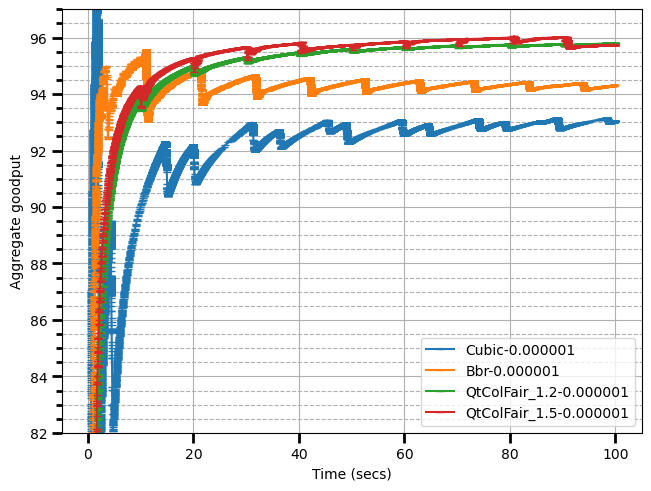

In [10]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0], agg_aveGoodput_value[0], '_-',
        agg_cwnd_time[1], agg_aveGoodput_value[1],'_-',
        agg_cwnd_time[2], agg_aveGoodput_value[2],'_-',
        agg_cwnd_time[3], agg_aveGoodput_value[3],'_-'
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(82,97)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[0].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
            tcp_cca[1].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
            tcp_cca[2].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
            tcp_cca[3].replace('minRTT','').replace('Tcp','').replace('-0.000100','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('multiple_lossy_flows/5_lossy_flows_goodput_0.0001.png', transparent=True)

/tmp/ipykernel_23105/2059630941.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


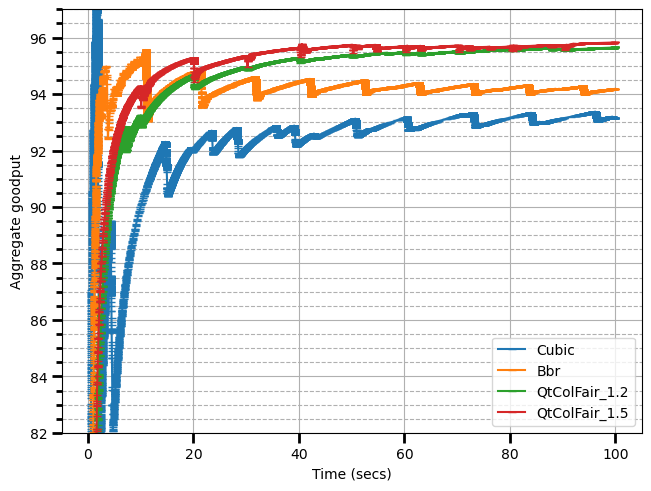

In [11]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[4], agg_aveGoodput_value[4], '_-',
        agg_cwnd_time[5], agg_aveGoodput_value[5],'_-',
        agg_cwnd_time[6], agg_aveGoodput_value[6],'_-',
        agg_cwnd_time[7], agg_aveGoodput_value[7],'_-'
        )
#ax1.step(
#        agg_cwnd_time[1], agg_aveGoodput_value[1],'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(82,97)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[4].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
            tcp_cca[5].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
            tcp_cca[6].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
            tcp_cca[7].replace('minRTT','').replace('Tcp','').replace('-0.000010','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('multiple_lossy_flows/5_lossy_flows_goodputt_0.00001.png', transparent=True)

/tmp/ipykernel_23105/1867905793.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


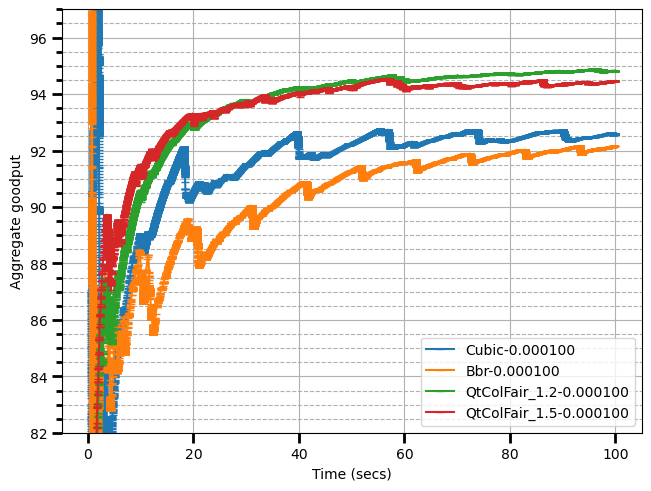

In [12]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[8], agg_aveGoodput_value[8], '_-',
        agg_cwnd_time[9], agg_aveGoodput_value[9],'_-',
        agg_cwnd_time[10], agg_aveGoodput_value[10],'_-',
        agg_cwnd_time[11], agg_aveGoodput_value[11],'_-'
        )
#ax1.step(
#        agg_cwnd_time[1], agg_aveGoodput_value[1],'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(82,97)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[8].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
            tcp_cca[9].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
            tcp_cca[10].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
            tcp_cca[11].replace('minRTT','').replace('Tcp','').replace('-0.000001','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('multiple_lossy_flows/5_lossy_flows_goodputt_0.000001.png', transparent=True)

In [16]:
G0 = agg_aveGoodput_value[0][len(agg_aveGoodput_value[0])-1]
G1 = agg_aveGoodput_value[1][len(agg_aveGoodput_value[1])-1]
G2 = agg_aveGoodput_value[2][len(agg_aveGoodput_value[2])-1]
G3 = agg_aveGoodput_value[3][len(agg_aveGoodput_value[3])-1]
G4 = agg_aveGoodput_value[4][len(agg_aveGoodput_value[4])-1]
G5 = agg_aveGoodput_value[5][len(agg_aveGoodput_value[5])-1]
G6 = agg_aveGoodput_value[6][len(agg_aveGoodput_value[6])-1]
G7 = agg_aveGoodput_value[7][len(agg_aveGoodput_value[7])-1]
G8 = agg_aveGoodput_value[8][len(agg_aveGoodput_value[8])-1]
G9 = agg_aveGoodput_value[9][len(agg_aveGoodput_value[9])-1]
G10 = agg_aveGoodput_value[10][len(agg_aveGoodput_value[10])-1]
G11 = agg_aveGoodput_value[11][len(agg_aveGoodput_value[11])-1]
G12 = agg_aveGoodput_value[12][len(agg_aveGoodput_value[12])-1]
G13 = agg_aveGoodput_value[13][len(agg_aveGoodput_value[13])-1]
G14 = agg_aveGoodput_value[14][len(agg_aveGoodput_value[14])-1]
G15 = agg_aveGoodput_value[15][len(agg_aveGoodput_value[15])-1]
G16 = agg_aveGoodput_value[16][len(agg_aveGoodput_value[16])-1]
G17 = agg_aveGoodput_value[17][len(agg_aveGoodput_value[17])-1]
G18 = agg_aveGoodput_value[18][len(agg_aveGoodput_value[18])-1]
G19 = agg_aveGoodput_value[19][len(agg_aveGoodput_value[19])-1]


In [21]:
print(G0[0])

93.0374


[93.0374, 93.1673, 92.5733, 56.7124, 12.9216]


/tmp/ipykernel_23105/3037307629.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


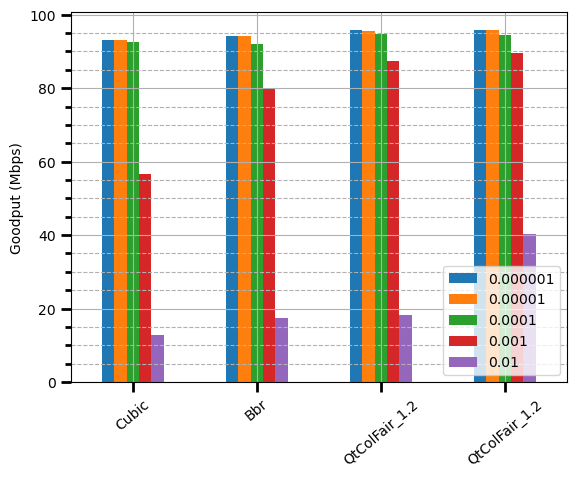

In [33]:
p000001 = [G0[0], G1[0], G2[0], G3[0]]
p00001 = [G4[0], G5[0], G6[0], G7[0]]
p0001 = [G8[0], G9[0], G10[0], G11[0]]
p001 = [G12[0], G13[0], G14[0], G15[0]]
p01 = [G16[0], G17[0], G18[0], G19[0]]

print(cubic)

index = [
        'Cubic', 'Bbr', 'QtColFair_1.2', 'QtColFair_1.2',
        ]

df = pd.DataFrame({'p000001': p000001, 'p00001': p00001, 'p0001': p0001,  
                   'p001': p001, 'p01': p01
                  }, index=index)

ax1 = df.plot.bar(rot=40)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.000001', '0.00001', '0.0001', '0.001', '0.01'], loc ="lower right")

plt.ylabel(r'Goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,97)
#plt.xlim(0,15)
plt.grid(True)

plt.show()

In [40]:
T0 = agg_aveThruput_value[0][len(agg_aveThruput_value[0])-1]
T1 = agg_aveThruput_value[1][len(agg_aveThruput_value[1])-1]
T2 = agg_aveThruput_value[2][len(agg_aveThruput_value[2])-1]
T3 = agg_aveThruput_value[3][len(agg_aveThruput_value[3])-1]
T4 = agg_aveThruput_value[4][len(agg_aveThruput_value[4])-1]
T5 = agg_aveThruput_value[5][len(agg_aveThruput_value[5])-1]
T6 = agg_aveThruput_value[6][len(agg_aveThruput_value[6])-1]
T7 = agg_aveThruput_value[7][len(agg_aveThruput_value[7])-1]
T8 = agg_aveThruput_value[8][len(agg_aveThruput_value[8])-1]
T9 = agg_aveThruput_value[9][len(agg_aveThruput_value[9])-1]
T10 = agg_aveThruput_value[10][len(agg_aveThruput_value[10])-1]
T11 = agg_aveThruput_value[11][len(agg_aveThruput_value[11])-1]
T12 = agg_aveThruput_value[12][len(agg_aveThruput_value[12])-1]
T13 = agg_aveThruput_value[13][len(agg_aveThruput_value[13])-1]
T14 = agg_aveThruput_value[14][len(agg_aveThruput_value[14])-1]
T15 = agg_aveThruput_value[15][len(agg_aveThruput_value[15])-1]
T16 = agg_aveThruput_value[16][len(agg_aveThruput_value[16])-1]
T17 = agg_aveThruput_value[17][len(agg_aveThruput_value[17])-1]
T18 = agg_aveThruput_value[18][len(agg_aveThruput_value[18])-1]
T19 = agg_aveThruput_value[19][len(agg_aveThruput_value[19])-1]

[93.0374, 93.1673, 92.5733, 56.7124, 12.9216]


/tmp/ipykernel_23105/2978681822.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


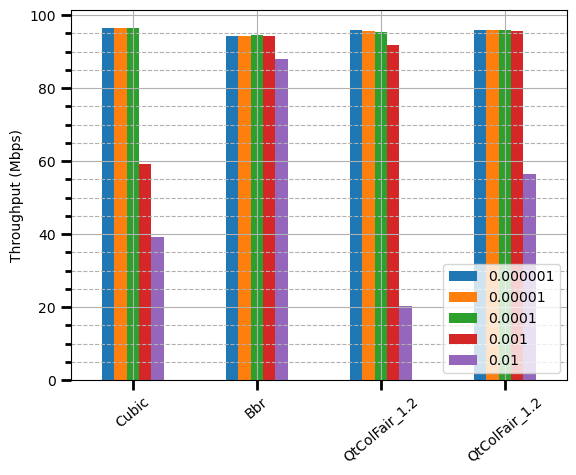

In [41]:
p000001 = [T0[0], T1[0], T2[0], T3[0]]
p00001 = [T4[0], T5[0], T6[0], T7[0]]
p0001 = [T8[0], T9[0], T10[0], T11[0]]
p001 = [T12[0], T13[0], T14[0], T15[0]]
p01 = [T16[0], T17[0], T18[0], T19[0]]

print(cubic)

index = [
        'Cubic', 'Bbr', 'QtColFair_1.2', 'QtColFair_1.2',
        ]

df = pd.DataFrame({'p000001': p000001, 'p00001': p00001, 'p0001': p0001,  
                   'p001': p001, 'p01': p01
                  }, index=index)

ax1 = df.plot.bar(rot=40)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.000001', '0.00001', '0.0001', '0.001', '0.01'], loc ="lower right")

plt.ylabel(r'Throughput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,97)
#plt.xlim(0,15)
plt.grid(True)

plt.show()

In [51]:
RTT0 = pd.DataFrame(agg_rtt_value[0]).to_numpy(dtype=float).mean()
RTT1 = pd.DataFrame(agg_rtt_value[1]).to_numpy(dtype=float).mean()
RTT2 = pd.DataFrame(agg_rtt_value[2]).to_numpy(dtype=float).mean()
RTT3 = pd.DataFrame(agg_rtt_value[3]).to_numpy(dtype=float).mean()
RTT4 = pd.DataFrame(agg_rtt_value[4]).to_numpy(dtype=float).mean()
RTT5 = pd.DataFrame(agg_rtt_value[5]).to_numpy(dtype=float).mean()
RTT6 = pd.DataFrame(agg_rtt_value[6]).to_numpy(dtype=float).mean()
RTT7 = pd.DataFrame(agg_rtt_value[7]).to_numpy(dtype=float).mean()
RTT8 = pd.DataFrame(agg_rtt_value[8]).to_numpy(dtype=float).mean()
RTT9 = pd.DataFrame(agg_rtt_value[9]).to_numpy(dtype=float).mean()
RTT10 = pd.DataFrame(agg_rtt_value[10]).to_numpy(dtype=float).mean()
RTT11 = pd.DataFrame(agg_rtt_value[11]).to_numpy(dtype=float).mean()
RTT12 = pd.DataFrame(agg_rtt_value[12]).to_numpy(dtype=float).mean()
RTT13 = pd.DataFrame(agg_rtt_value[13]).to_numpy(dtype=float).mean()
RTT14 = pd.DataFrame(agg_rtt_value[14]).to_numpy(dtype=float).mean()
RTT15 = pd.DataFrame(agg_rtt_value[15]).to_numpy(dtype=float).mean()
RTT16 = pd.DataFrame(agg_rtt_value[16]).to_numpy(dtype=float).mean()
RTT17 = pd.DataFrame(agg_rtt_value[17]).to_numpy(dtype=float).mean()
RTT18 = pd.DataFrame(agg_rtt_value[18]).to_numpy(dtype=float).mean()
RTT19 = pd.DataFrame(agg_rtt_value[19]).to_numpy(dtype=float).mean()

print(RTT0)

0.22333535121197196


[93.0374, 93.1673, 92.5733, 56.7124, 12.9216]


/tmp/ipykernel_23105/1298574285.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


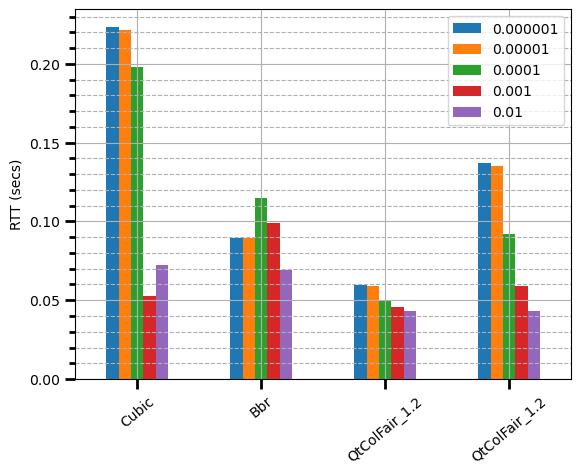

In [53]:
p000001 = [RTT0, RTT1, RTT2, RTT3]
p00001 = [RTT4, RTT5, RTT6, RTT7]
p0001 = [RTT8, RTT9, RTT10, RTT11]
p001 = [RTT12, RTT13, RTT14, RTT15]
p01 = [RTT16, RTT17, RTT18, RTT19]

print(cubic)

index = [
        'Cubic', 'Bbr', 'QtColFair_1.2', 'QtColFair_1.2',
        ]

df = pd.DataFrame({'p000001': p000001, 'p00001': p00001, 'p0001': p0001,  
                   'p001': p001, 'p01': p01
                  }, index=index)

ax1 = df.plot.bar(rot=40)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.000001', '0.00001', '0.0001', '0.001', '0.01'], loc ="best")

plt.ylabel(r'RTT (secs)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,97)
#plt.xlim(0,15)
plt.grid(True)

plt.show()